# Cabeçalho - TODO (escrever bonitinho)

## Resumo do trabalho - TODO (escrever bonitinho)

## Importando bibliotecas

In [1]:
%matplotlib inline
%lsmagic

import time
import math

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

## Definindo funções úteis

In [2]:
def graficos_boxplot(X, colunas=None, grupo=None, restricoes=None):
    
    if grupo == None:
        print ('nenhum grupo informado')
        return None
    
    if colunas == None: colunas = X.columns.tolist()
    
    dado = X[colunas + [grupo]].copy()
    
    for col in colunas:
        plt.figure(figsize=(16, 4))
        ax = sns.boxplot(x=grupo, y=col, data=dado)
        plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
    return

def detectar_outliers(X, colunas=None, metodo='one class svm', contamination=0.1):
    
    if colunas == None: colunas = X.columns.tolist()
    
    x_local = X[colunas].copy()
    
    col_num = x_local.select_dtypes(include = ['float64', 'int64']).columns.tolist()
    col_cat = x_local.select_dtypes(include = ['object']).columns.tolist()
    
    for col in col_cat:
        enc = LabelEncoder()
        x_local[col] = enc.fit_transform(x_local[col].astype(str))
        
    for col in col_num:
        x_local[col].fillna(0, inplace=True)
        
    x_local['is outlier'] = 0
    
    dado = x_local[colunas]
    
    isolation_forest = IsolationForest(n_estimators=100, behaviour='new', contamination=contamination)
    robust_covariance = EllipticEnvelope(contamination=contamination)
    OneClassSVM = svm.OneClassSVM(kernel='poly', degree=2, gamma=1000, tol=0.1, nu=contamination)
    local_out_factor = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
    
    if metodo == 'one class svm': out = OneClassSVM
    if metodo == 'isolation forest': out = isolation_forest
    if metodo == 'robust covariance': out = robust_covariance
    if metodo == 'local outlier fraction': out = local_out_factor
    
    if metodo == 'local outlier fraction':
        dado['is outlier'] = out.fit_predict(dado)
    else:
        out.fit(dado)
        dado['is outlier'] = out.predict(dado)
    
    mask = dado[dado['is outlier'] == -1].index.tolist()
    x_local.loc[mask, 'is outlier'] = 1
    
    return x_local['is outlier']

def preencher_buracos(X, coluna, valor = None, coluna_grupo = None):
    if valor != None: 
        X[coluna].fillna(valor, inplace=True)
    elif coluna_grupo == coluna:
        X[coluna].fillna(X[coluna].mean())
    else:
        mask = X[coluna].isnull()
        replace_dict = X[coluna, coluna_grupo].groupby(coluna_grupo).mean().to_dict()[coluna]
        X.loc[mask, coluna] = X[coluna_grupo][mask].replace(replace_dict)
    return X

def normalizar_numericas(X, colunas_numericas = None):
    if colunas_numericas == None: colunas_numericas = X.columns.tolist()
    scaler = RobustScaler()
    X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
    return X, scaler

def codificar_categoricas(X, colunas_categoricas = None):
    if colunas_categoricas == None: colunas_categoricas = X.columns.tolist()
    colunas_numericas = [x for x in X.columns.tolist() if x not in colunas_categoricas]
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = pd.DataFrame(enc.fit_transform(X[colunas_categoricas]).toarray())
    X.reset_index(inplace=True, drop=True)
    res = pd.concat([X_cat, X[colunas_numericas]], axis=1)
    return res, enc

def fitar_modelo(modelo, X, y, X_test = None, y_test = None):
    modelo.fit(X, y)
    train_score = r2_score(y, modelo.predict(X))
    test_score = r2_score(y_test, modelo.predict(X_test))
    if X_test == None:
        return modelo, train_score
    else:
        return modelo, train_score, test_score

def importancia_das_features(X, y, colunas_numericas = None, colunas_categoricas = None, nome_variavel = ''): 
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None: x_local, _ = normalizar_numericas(x_local, colunas_numericas)
    if colunas_categoricas != None:
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    features_names = x_local.columns
    
    rf_importance = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rf_importance.fit(x_local, y_local)
    
    feature_importances = list(rf_importance.feature_importances_)
    list_tuples = zip(features_names, feature_importances)
    
    plt.figure(123)
    plt.figure(figsize=(5, 10))
    features_names_sort, feature_importances_sort = zip(*sorted(list_tuples, key=lambda x:x[1], reverse=False)[:50])
    plt.barh(range(len(feature_importances_sort)), feature_importances_sort)
    plt.yticks(np.arange(len(features_names_sort)), features_names_sort)
    plt.title('Feature Importances - ' + nome_variavel)
    plt.show()
    
    return features_names_sort, feature_importances_sort

def calcular_correlação(X, colunas_numericas=None, colunas_categoricas=None):
    
    x_local = X.copy()
    colunas = []
    
    if colunas_numericas != None:
        x_local, _ = normalizar_numericas(x_local, colunas_numericas)
        colunas = colunas + colunas_numericas
    if colunas_categoricas != None:
        colunas = colunas + colunas_categoricas
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    correlacao = {}
    for col in colunas:
        val = x_local.drop(col, axis=1).apply(lambda x: x.corr(x_local[col]))
        correlacao[col] = val.sort_values(ascending=False)
    
    df = pd.DataFrame(correlacao)
            
    return df

def selecionar_features(X, y, y_name=None, colunas_numericas=None, colunas_categoricas=None, limite_corr=0.8, limite_importancia=0.8, quantidade=999):
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    elif colunas_numericas != None and colunas_categoricas == None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, nome_variavel = y_name)
    elif colunas_numericas == None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    else:
        print ("algo errado ai meu camarada")
        return None
    
    features = corr.columns.tolist()
    features_slct = []
    count = 0
    for f, v in zip(reversed(features_names_sort), reversed(feature_importances_sort)):
        print (f, v)
        if count > quantidade: break
        add = True
        if float(v) > limite_importancia: add = False
        for f_f in features_slct:
            if v < 0.001 or abs(corr.loc[f, f_f]) > limite_corr: add = False
        if add: 
            features_slct.append(f)
            count += 1
    
    x_features_slct = x_local[features_slct]
    return x_features_slct, features_slct

def busca_aleatoria(X, y, modelo, parametros, metrica, n_folds = 10, n_iter = 200):
    
    start_time = time.time()
    
    print ("\n \n buscando melhores parâmetros...")
    
    otm_model = RandomizedSearchCV(modelo, param_distributions=parametros, n_iter=n_iter, 
                                   scoring=metrica, cv=n_folds, n_jobs=1, refit=list(metrica.keys())[0])
    otm_model.fit(X, y)
    
    melhores_parametros = otm_model.best_params_
    melhor_modelo = otm_model.best_estimator_
    
    resultados = pd.DataFrame(otm_model.cv_results_)
    print (resultados)
    resultados.sort_values(by='rank_test_'+str(list(metrica.keys())[0]), inplace=True)
    resultados.sort_values(by='rank_test_'+str(list(metrica.keys())[0]), inplace=True)
    print ("melhores parâmetros encontrados")
    
    end_time = time.time()
    otm_time = (end_time - start_time) / 60
    
    best_score = otm_model.best_score_
    
    return melhor_modelo, melhores_parametros, best_score, resultados, otm_time

## Importando o dado

In [3]:
ls data/

Fat_Supply_Quantity_Data.csv      Protein_Supply_Quantity_Data.csv
Food_Supply_kcal_Data.csv         readme.txt
Food_Supply_Quantity_kg_Data.csv  Supply_Food_Data_Descriptions.csv


In [4]:
fat_df = pd.read_csv('./data/Fat_Supply_Quantity_Data.csv')

In [5]:
fat_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [6]:
protein_df = pd.read_csv('./data/Protein_Supply_Quantity_Data.csv')

In [7]:
protein_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [8]:
kcal_df = pd.read_csv('./data/Food_Supply_kcal_Data.csv')

In [9]:
kcal_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [10]:
quantity_kg_df = pd.read_csv('./data/Food_Supply_Quantity_kg_Data.csv')

In [11]:
quantity_kg_df.head()

,Country,Alcoholic Beverages,Animal fats,Animal Products,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Vegetal Products,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0014,0.1973,9.4341,0.0,24.8097,0.2099,0.0350,5.3495,1.2020,...,6.7642,40.5645,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,1.6719,0.1357,18.7684,0.0,5.7817,0.5815,0.2126,6.7861,1.8845,...,11.7753,31.2304,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.2711,0.0282,9.6334,0.0,13.6816,0.5277,0.2416,6.3801,1.1305,...,11.6484,40.3651,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,5.8087,0.0560,4.9278,0.0,9.1085,0.0587,1.7707,6.0005,2.0571,...,2.3041,45.0722,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,3.5764,0.0087,16.6613,0.0,5.9960,0.2274,4.1489,10.7451,5.6888,...,5.4495,33.3233,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [12]:
description_df = pd.read_csv('./data/Supply_Food_Data_Descriptions.csv')

In [13]:
description_df.head()

,Categories,Items
0,Alcoholic Beverages,"Alcohol, Non-Food; Beer; Beverages, Alcoholic;..."
1,Animal fats,"Butter, Ghee; Cream; Fats, Animals, Raw; Fish,..."
2,Animal Products,"Aquatic Animals, Others; Aquatic Plants; Bovin..."
3,"Aquatic Products, Other","Aquatic Animals, Others; Aquatic Plants; Meat,..."
4,Cereals - Excluding Beer,"Barley and products; Cereals, Other; Maize and..."


## Juntando datasets

In [14]:
dfs = [fat_df, protein_df, kcal_df, quantity_kg_df, description_df]

In [15]:
for df in dfs:
    print (df.shape)

(170, 32)
(170, 32)
(170, 32)
(170, 32)
(23, 2)


In [16]:
cols = {}
i = 0
for df in dfs[:-1]:
    i += 1
    cols['df'+str(i)] = list(df.columns)
df_cols = pd.DataFrame(cols)

In [17]:
df_cols

,df1,df2,df3,df4
0,Country,Country,Country,Country
1,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages
2,Animal Products,Animal Products,Animal Products,Animal fats
3,Animal fats,Animal fats,Animal fats,Animal Products
4,"Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other"
5,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer
6,Eggs,Eggs,Eggs,Eggs
7,"Fish, Seafood","Fish, Seafood","Fish, Seafood","Fish, Seafood"
8,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine
9,Meat,Meat,Meat,Meat


In [18]:
shared_cols = ['Country', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']

In [19]:
dataset = fat_df[shared_cols].copy()

In [20]:
dataset.head()

,Country,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [21]:
cols = list(fat_df.columns)

In [22]:
cols = ['Country'] + [i for i in cols if i not in shared_cols]

In [23]:
fat_df = fat_df[cols].copy()

In [24]:
protein_df = protein_df[cols].copy()

In [25]:
kcal_df = kcal_df[cols].copy()

In [26]:
quantity_kg_df = quantity_kg_df[cols].copy()

In [27]:
fat_cols_map = {i:i+'_fat' for i in cols if i != 'Country'}

In [28]:
protein_cols_map = {i:i+'_protein' for i in cols if i != 'Country'}

In [29]:
kcal_cols_map = {i:i+'_kcal' for i in cols if i != 'Country'}

In [30]:
quant_cols_map = {i:i+'_quantity' for i in cols if i != 'Country'}

In [31]:
fat_df.rename(fat_cols_map, axis=1, inplace=True)

In [32]:
protein_df.rename(protein_cols_map, axis=1, inplace=True)

In [33]:
kcal_df.rename(kcal_cols_map, axis=1, inplace=True)

In [34]:
quantity_kg_df.rename(quant_cols_map, axis=1, inplace=True)

In [35]:
dataset = dataset.merge(fat_df, how='left', on='Country', copy=False)

In [36]:
dataset = dataset.merge(protein_df, how='left', on='Country', copy=False)

In [37]:
dataset = dataset.merge(kcal_df, how='left', on='Country', copy=False)

In [38]:
dataset = dataset.merge(quantity_kg_df, how='left', on='Country', copy=False)

In [39]:
dataset.shape

(170, 101)

## Analisando o dado

**TODO: testar pandas-profile**

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Columns: 101 entries, Country to Vegetables_quantity
dtypes: float64(98), object(3)
memory usage: 135.5+ KB


In [41]:
dataset.dtypes.value_counts()

float64    98
object      3
dtype: int64

In [42]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
data_cat = dataset.select_dtypes(include = ['object'])

In [43]:
data_cat.head()

,Country,Undernourished,Unit (all except Population)
0,Afghanistan,29.8,%
1,Albania,6.2,%
2,Algeria,3.9,%
3,Angola,25,%
4,Antigua and Barbuda,NaN,%


In [44]:
data_num.describe()

,Obesity,Confirmed,Deaths,Recovered,Active,Population,Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",...,Pulses_quantity,Spices_quantity,Starchy Roots_quantity,Stimulants_quantity,Sugar Crops_quantity,Sugar & Sweeteners_quantity,Treenuts_quantity,Vegetal Products_quantity,Vegetable Oils_quantity,Vegetables_quantity
count,167.000000,161.000000,161.000000,161.000000,161.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,18.707784,0.083872,0.004454,0.042839,0.036576,4.408395e+07,0.001035,20.695714,4.138451,0.000450,...,0.537131,0.091011,5.335371,0.201946,0.095846,2.799115,0.117474,37.814834,0.851554,6.085912
std,9.633557,0.127583,0.011492,0.085173,0.067335,1.556265e+08,0.009569,8.002713,3.287462,0.004039,...,0.601111,0.121898,5.571355,0.189239,0.379936,1.545951,0.146143,5.852943,0.445335,3.560148
min,2.100000,0.000047,0.000000,0.000000,0.000000,5.300000e+04,0.000000,5.018200,0.026200,0.000000,...,0.000000,0.000000,0.679600,0.004200,0.000000,0.366600,0.000000,23.113200,0.091500,0.857000
25%,8.500000,0.006013,0.000147,0.002235,0.001395,2.822750e+06,0.000000,14.885800,1.674225,0.000000,...,0.129650,0.016500,2.023825,0.083325,0.000000,1.721025,0.020750,33.552775,0.507700,3.616500
50%,21.200000,0.022222,0.000545,0.009806,0.008685,1.014600e+07,0.000000,20.943050,3.312350,0.000000,...,0.300800,0.042550,3.108650,0.159450,0.000000,2.601650,0.079950,37.900700,0.774450,5.028100
75%,25.700000,0.116800,0.002828,0.048328,0.030238,3.169250e+07,0.000000,26.866950,6.227575,0.000000,...,0.734900,0.123150,5.745875,0.261800,0.000000,3.782150,0.148650,42.762775,1.070900,7.801650
max,45.600000,0.640484,0.079857,0.601290,0.353151,1.398030e+09,0.097600,36.901800,14.937300,0.051100,...,3.483800,0.662600,27.712800,1.282300,3.067700,9.725900,0.756900,48.258500,2.202600,19.299500


In [45]:
dataset.isnull().sum()

Country                        0
Obesity                        3
Undernourished                 7
Confirmed                      9
Deaths                         9
                              ..
Sugar & Sweeteners_quantity    0
Treenuts_quantity              0
Vegetal Products_quantity      0
Vegetable Oils_quantity        0
Vegetables_quantity            0
Length: 101, dtype: int64

In [46]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 3
Undernourished 7
Confirmed 9
Deaths 9
Recovered 9
Active 9


In [47]:
dataset = dataset[dataset['Confirmed'].isnull() != True]

In [48]:
dataset.shape

(161, 101)

In [49]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 1
Undernourished 7


In [50]:
dataset['Undernourished'].unique()

array(['29.8', '6.2', '3.9', '25', nan, '4.6', '4.3', '<2.5', '14.7',
       '7.5', '10.1', '17.1', '26.4', '3.6', '20', '12.6', '16.4', '9.9',
       '59.6', '37.5', '2.7', '8.5', '4.8', '40.3', '19', '5.6', '18.9',
       '9.5', '7.9', '4.5', '9', '2.9', '20.6', '3.7', '10.5', '10.2',
       '5.5', '15.2', '16.5', '28', '8.1', '49.3', '12.9', '14.5', '8.3',
       '4.9', '29', '8', '12.2', '29.4', '2.8', '7.1', '11', '13.1',
       '37.2', '44.4', '17.5', '2.5', '10.3', '6.3', '10.4', '6.5',
       '13.4', '3.4', '27.9', '27.3', '8.7', '17', '3.2', '6.8', '20.3',
       '10', '10.7', '9.7', '13.3', '36.8', '5.7', '7', '11.3', '25.6',
       '20.1', '3.5', '7.8', '24.9', '16.1', '41', '2.6', '30.7', '21.2',
       '9.3', '38.9', '46.7', '51.3'], dtype=object)

In [51]:
dataset.loc[dataset['Undernourished'] == '<2.5', 'Undernourished'] = '2.5'

In [52]:
dataset['Undernourished'] = dataset['Undernourished'].astype(float)

In [53]:
dataset['Obesity'].unique()

array([ 4.5, 22.3, 26.6,  6.8, 19.1, 28.5, 20.9, 30.4, 21.9, 19.9, 32.1,
        3.4, 24.8, 24.5, 22.4,  8.2, 18.7, 19.4, 16.1, 27.4, 10.6,  3.5,
        9.5, 31.3,  6.3,  4.8, 28.8,  6.6, 22.1,  8.4, 25.7,  9. , 27.1,
       26.7, 22.6, 21.3, 12.2, 28.2, 26.9, 19.3, 31.1, 22.7, 23.8, 13.5,
        3.6, 30. , 24.9, 23.2, 13.4,  8.7, 23.3,  9.7, 20.2, 18.8, 19.2,
       20.5, 28.6, 23.1,  3.8,  6.9, 25.5, 22.9, 24.4,  4.4, 33.4,  6. ,
        4.9, 37. , 15.4,  8.6, 28.4, 24.2,  4.7, 15.3,  7.9,  7.1, 31. ,
       11.3, 11.5, 19.6, 25.6, 15. , 32. , 21.8,  7.8, 23.9, 25. , 22.5,
       19. , 20.1, 19.8, 35. ,  7.4, 23.5,  7.5, 27. ,  5.4, 26.5, 21.2,
        nan, 12.6, 10.8,  2.9, 19.7, 27.3, 32.2,  4.1, 26.1, 29.9, 29.5,
       37.3, 28.9, 25.2,  2.1, 14.1,  6.5, 12.3])

In [54]:
dataset['Obesity'] = dataset['Obesity'].astype(float)

In [55]:
dataset['Obesity'].fillna(dataset['Obesity'].mean(), inplace=True)

In [56]:
dataset['Undernourished'].fillna(dataset['Undernourished'].mean(), inplace=True)

In [57]:
dataset.isnull().sum().unique()

array([0])

## Correlações importantes (Golden features)

In [58]:
targets = ['Confirmed', 'Deaths', 'Recovered', 'Active']

In [59]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
for t in targets:
    data_corr = data_num.corr()[t]
    golden_features_list = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False)
    print (t, golden_features_list)

Confirmed Confirmed                            1.000000
Recovered                            0.823831
Active                               0.730086
Deaths                               0.717421
Animal Products_kcal                 0.482963
Animal Products_protein              0.471756
Animal Products_quantity             0.454655
Eggs_kcal                            0.429222
Milk - Excluding Butter_protein      0.423439
Obesity                              0.419346
Animal fats_quantity                 0.405072
Milk - Excluding Butter_kcal         0.401307
Animal fats_kcal                     0.395164
Stimulants_kcal                      0.386813
Eggs_protein                         0.384428
Milk - Excluding Butter_quantity     0.379119
Alcoholic Beverages_kcal             0.369625
Animal fats_fat                      0.350306
Animal Products_fat                  0.344300
Meat_kcal                            0.341846
Treenuts_kcal                        0.336915
Meat_protein            

**TODO: fazer uns gráficos das correlações (golden features): gráfico de barras ordenado, 1 para correlações positivas e 1 para correlações negativas, por cada target (total de 8 gráficos)**

## Remover outliers

In [60]:
colunas_outlier = data_num.columns.to_list()

dataset['is outlier'] = detectar_outliers(dataset, colunas=colunas_outlier, metodo='local outlier fraction', 
                                          contamination=0.01)
print (str(list(dataset['is outlier']).count(1)) + ' outliers detectados')
dataset = dataset[dataset['is outlier']==0]

2 outliers detectados


## Separando features das targets

In [61]:
y_dict = {}
for t in targets:
    y_dict[t] = dataset[t]

## Feature engineering

In [62]:
cols = dataset.columns.to_list()

In [63]:
features = [f for f in cols if f not in targets]

x_features = dataset[features].copy()

In [64]:
x_features.head()

,Country,Obesity,Undernourished,Population,Unit (all except Population),Alcoholic Beverages_fat,Animal Products_fat,Animal fats_fat,"Aquatic Products, Other_fat",Cereals - Excluding Beer_fat,...,Spices_quantity,Starchy Roots_quantity,Stimulants_quantity,Sugar Crops_quantity,Sugar & Sweeteners_quantity,Treenuts_quantity,Vegetal Products_quantity,Vegetable Oils_quantity,Vegetables_quantity,is outlier
0,Afghanistan,4.5,29.800000,38042000.0,%,0.0,21.6397,6.2224,0.0,8.0353,...,0.0574,0.8802,0.3078,0.0,1.3489,0.0770,40.5645,0.5345,6.7642,0
1,Albania,22.3,6.200000,2858000.0,%,0.0,32.0002,3.4172,0.0,2.6734,...,0.0008,1.8096,0.1055,0.0,1.5367,0.1515,31.2304,0.3261,11.7753,0
2,Algeria,26.6,3.900000,43406000.0,%,0.0,14.4175,0.8972,0.0,4.2035,...,0.0557,4.1340,0.2216,0.0,1.8342,0.1152,40.3651,1.0310,11.6484,0
3,Angola,6.8,25.000000,31427000.0,%,0.0,15.3041,1.3130,0.0,6.5545,...,0.0009,18.1102,0.0508,0.0,1.8495,0.0061,45.0722,0.6463,2.3041,0
4,Antigua and Barbuda,19.1,11.258442,97000.0,%,0.0,27.7033,4.6686,0.0,3.2153,...,0.1524,1.4522,0.1564,0.0,3.8749,0.0253,33.3233,0.8102,5.4495,0


In [65]:
del x_features['Unit (all except Population)']

In [66]:
del x_features['is outlier']

In [67]:
x_features.dtypes.value_counts()

float64    95
object      1
dtype: int64

In [68]:
x_features_orig = x_features.copy()

In [69]:
data_num = x_features.select_dtypes(include = ['float64', 'int64'])
data_cat = x_features.select_dtypes(include = ['object'])
colunas_a_normalizar = data_num.columns.tolist()
colunas_a_codificar = data_cat.columns.tolist()

<Figure size 432x288 with 0 Axes>

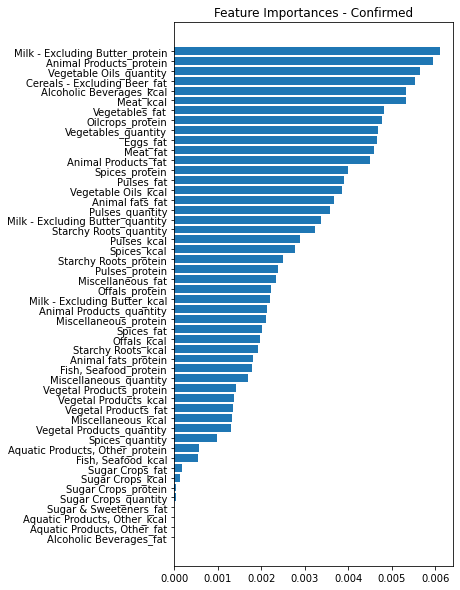

<Figure size 432x288 with 0 Axes>

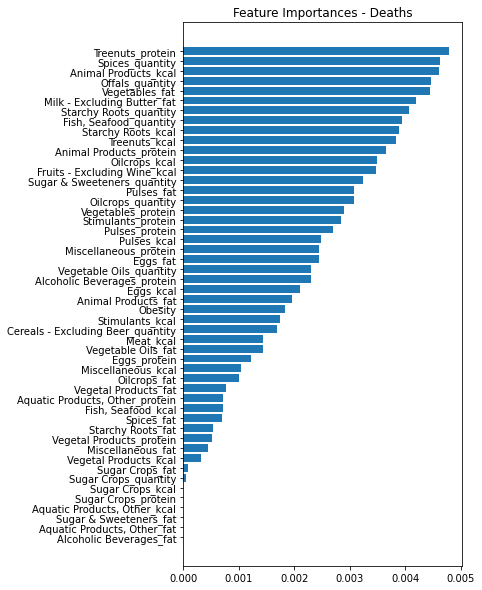

<Figure size 432x288 with 0 Axes>

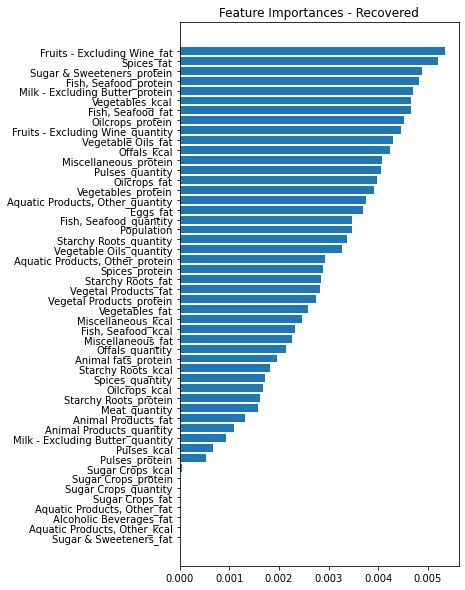

<Figure size 432x288 with 0 Axes>

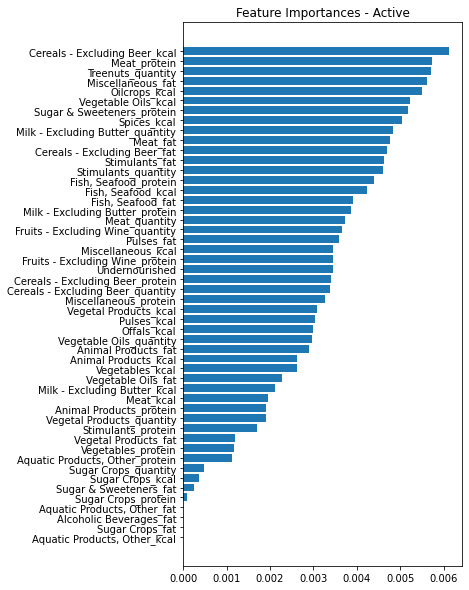

In [70]:
features_importances_dict = {}
features_names_dict = {}
for t in targets:
    features_names_sort, feature_importances_sort = importancia_das_features(x_features, y_dict[t], colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, nome_variavel = t)
    features_importances_dict[t] = feature_importances_sort
    features_names_dict[t] = features_names_sort

**TODO: colorir gráfico de acordo com sinal (negativo ou positivo) da correlação**

<Figure size 432x288 with 0 Axes>

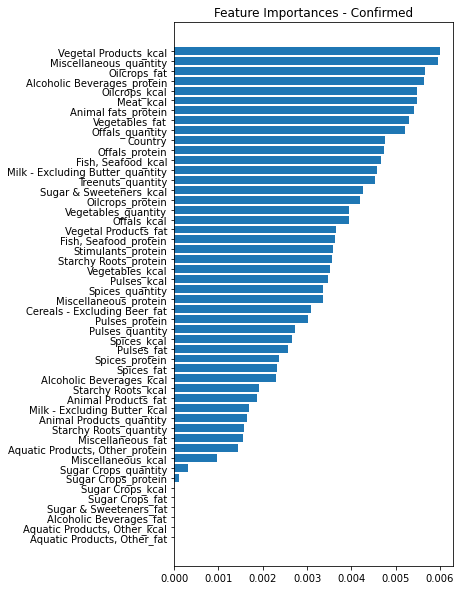

Vegetal Products_kcal 0.005994958140525881
Miscellaneous_quantity 0.005949249758122302
Oilcrops_fat 0.00565001177150071
Alcoholic Beverages_protein 0.005631526981604648
Oilcrops_kcal 0.005489584438456686
Meat_kcal 0.005484511858784957
Animal fats_protein 0.005421984940337517
Vegetables_fat 0.005305780967213193
Offals_quantity 0.0052132600114859805
Country 0.004756124675497388
Offals_protein 0.004734119951384611
Fish, Seafood_kcal 0.00466073016743278
Milk - Excluding Butter_quantity 0.004578708017825853
Treenuts_quantity 0.004526111620452073
Sugar & Sweeteners_kcal 0.004266685946450143
Oilcrops_protein 0.004191737471364423
Vegetables_quantity 0.003951802570531604
Offals_kcal 0.003943557544090503
Vegetal Products_fat 0.0036532930253938205
Fish, Seafood_protein 0.0036374646989854416
Stimulants_protein 0.0035836564721877483
Starchy Roots_protein 0.0035669560468374367
Vegetables_kcal 0.003510791341647004
Pulses_kcal 0.0034749661154235808
Spices_quantity 0.003360644746653757
Miscellaneous_pr

<Figure size 432x288 with 0 Axes>

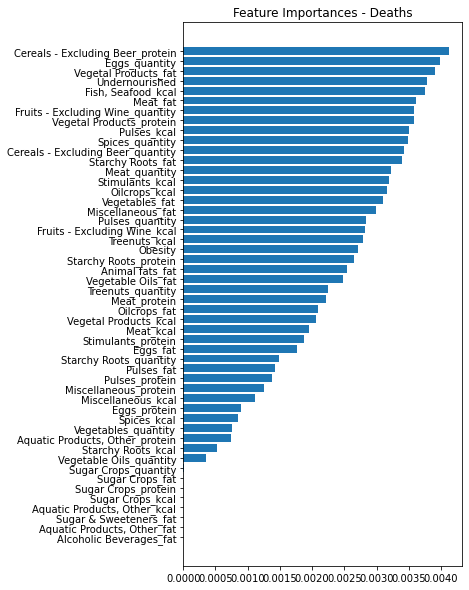

Cereals - Excluding Beer_protein 0.00412334137168221
Eggs_quantity 0.003982084210622665
Vegetal Products_fat 0.003914767074100647
Undernourished 0.0037881474116879393
Fish, Seafood_kcal 0.0037580684404867927
Meat_fat 0.0036183090389914747
Fruits - Excluding Wine_quantity 0.003581896417129213
Vegetal Products_protein 0.0035743284476950506
Pulses_kcal 0.003502931191792247
Spices_quantity 0.0034826289078513056
Cereals - Excluding Beer_quantity 0.00342270082740393
Starchy Roots_fat 0.003401405927045665
Meat_quantity 0.0032312047767680506
Stimulants_kcal 0.0031878633319495486
Oilcrops_kcal 0.003163616444406454
Vegetables_fat 0.0031052905608723955
Miscellaneous_fat 0.0029860579919053563
Pulses_quantity 0.0028407465730264253
Fruits - Excluding Wine_kcal 0.0028200965990628833
Treenuts_kcal 0.0027858500773783722
Obesity 0.002706237378156382
Starchy Roots_protein 0.002647331621377674
Animal fats_fat 0.0025352388857291675
Vegetable Oils_fat 0.002478122078642283
Treenuts_quantity 0.002246937138151

<Figure size 432x288 with 0 Axes>

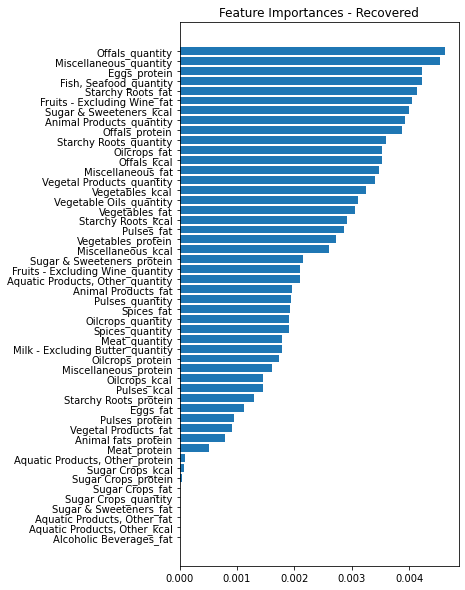

Offals_quantity 0.004629856783029446
Miscellaneous_quantity 0.004541793101606694
Eggs_protein 0.004229627803774675
Fish, Seafood_quantity 0.00422831243381588
Starchy Roots_fat 0.004144298424629985
Fruits - Excluding Wine_fat 0.0040429943566964825
Sugar & Sweeteners_kcal 0.0039915867275282305
Animal Products_quantity 0.003930717600229021
Offals_protein 0.003867720511768866
Starchy Roots_quantity 0.00359658603589687
Oilcrops_fat 0.0035333138935351345
Offals_kcal 0.003523264062474405
Miscellaneous_fat 0.0034816678570162313
Vegetal Products_quantity 0.0034053195647072137
Vegetables_kcal 0.0032454309105437074
Vegetable Oils_quantity 0.003104410209583452
Vegetables_fat 0.0030518857595918485
Starchy Roots_kcal 0.0029156703248030824
Pulses_fat 0.0028700114224081007
Vegetables_protein 0.002727566560796463
Miscellaneous_kcal 0.0026008220626191777
Sugar & Sweeteners_protein 0.002156092707313604
Fruits - Excluding Wine_quantity 0.0021041357818782917
Aquatic Products, Other_quantity 0.0020986688542

<Figure size 432x288 with 0 Axes>

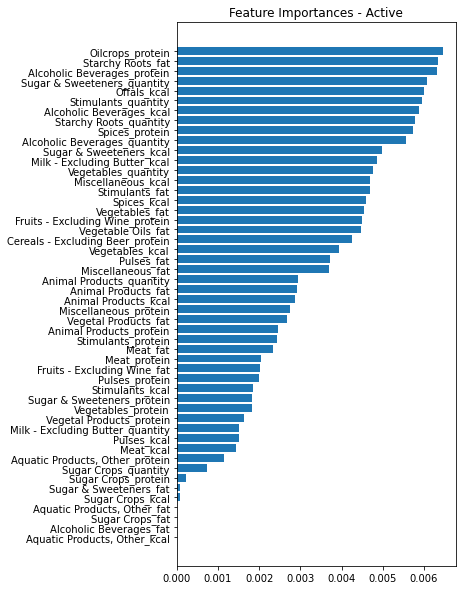

Oilcrops_protein 0.006454213088948601
Starchy Roots_fat 0.006355327303331147
Alcoholic Beverages_protein 0.006309800422687654
Sugar & Sweeteners_quantity 0.006084190915027725
Offals_kcal 0.006015437817385799
Stimulants_quantity 0.005950014794224641
Alcoholic Beverages_kcal 0.005874260290527594
Starchy Roots_quantity 0.005778332114991756
Spices_protein 0.005727658640195929
Alcoholic Beverages_quantity 0.005578701828178003
Sugar & Sweeteners_kcal 0.004986628783968184
Milk - Excluding Butter_kcal 0.004873874917695877
Vegetables_quantity 0.004755815478045662
Miscellaneous_kcal 0.004689658990449337
Stimulants_fat 0.0046829416455780645
Spices_kcal 0.004594040624337712
Vegetables_fat 0.0045351425460189495
Fruits - Excluding Wine_protein 0.0045098160251037835
Vegetable Oils_fat 0.004479335203985777
Cereals - Excluding Beer_protein 0.004245572041349969
Vegetables_kcal 0.003943679019993472
Pulses_fat 0.0037246340041236716
Miscellaneous_fat 0.003707777970058882
Animal Products_quantity 0.00294069

In [71]:
x_features_slct = {}
features_slct = {}
for t in targets:
    x_features_slct[t], features_slct[t] = selecionar_features(x_features, y_dict[t], y_name=t, colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, limite_corr=0.9, limite_importancia=0.99, quantidade=99)


In [72]:
for t in targets:
    print (t + " " +str(len(features_slct[t])))

Confirmed 26
Deaths 25
Recovered 26
Active 29


<Figure size 432x288 with 0 Axes>

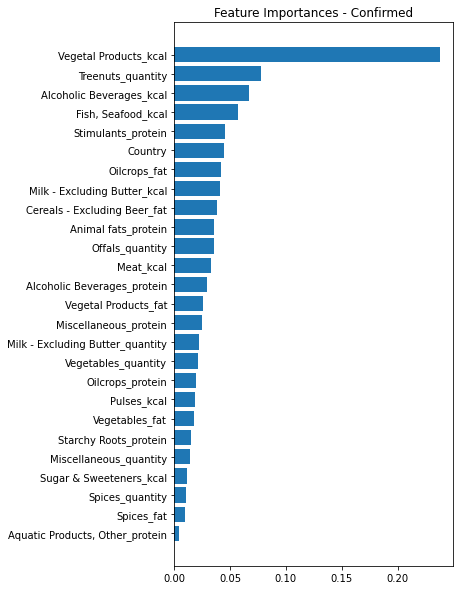

<Figure size 432x288 with 0 Axes>

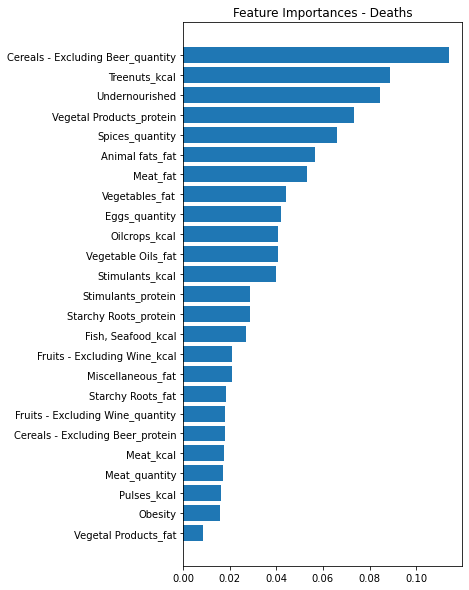

<Figure size 432x288 with 0 Axes>

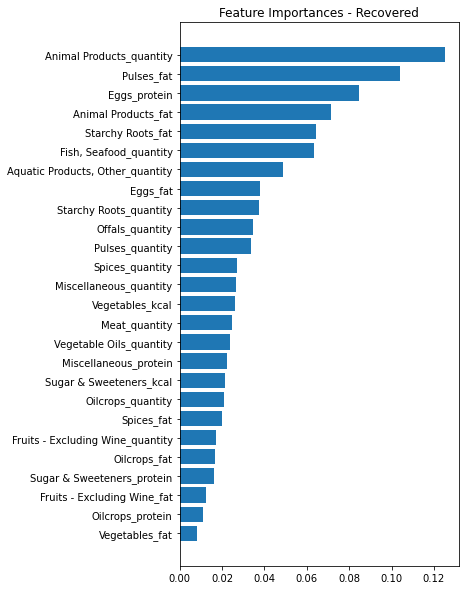

<Figure size 432x288 with 0 Axes>

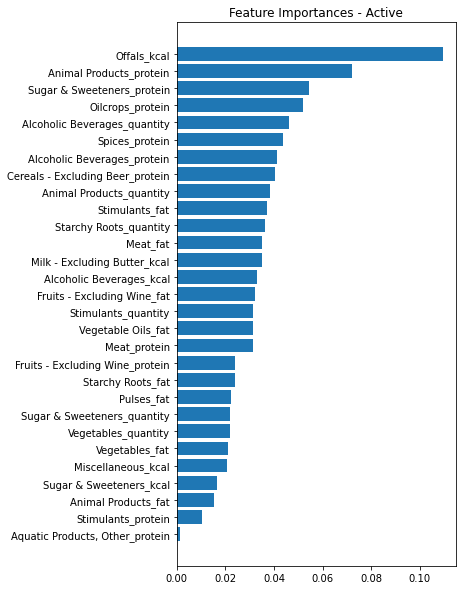

In [73]:
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_num_slct = data_num.columns.tolist()
    colunas_categ_slct = data_cat.columns.tolist()
    
    x_features_importance_pratica = x_features_slct[t][features_slct[t]]
    
    features_names_sort_slct, feature_importances_sort_slct = importancia_das_features(x_features_importance_pratica, y_dict[t], colunas_numericas=colunas_num_slct, colunas_categoricas = colunas_categ_slct, nome_variavel = t)


## Separando dado de treino e teste

In [74]:
x_train_dict = {}
y_train_dict = {}
x_test_dict = {}
y_test_dict = {}

for t in targets:
    x_train_dict[t], x_test_dict[t], y_train_dict[t], y_test_dict[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.2, random_state=42)
    print (y_train_dict[t].shape, y_test_dict[t].shape)

(127,) (32,)
(127,) (32,)
(127,) (32,)
(127,) (32,)


## Pré processamento

In [75]:
colunas_a_normalizar = {}
colunas_a_codificar = {}
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_a_normalizar[t] = data_num.columns.tolist()
    colunas_a_codificar[t] = data_cat.columns.tolist()

scaler_dict = {}
for t in targets:
    _, scaler = normalizar_numericas(x_train_dict[t], colunas_a_normalizar[t])
    scaler_dict[t] = scaler
    x_test_dict[t][colunas_a_normalizar[t]] = scaler_dict[t].transform(x_test_dict[t][colunas_a_normalizar[t]])

encoder_dict = {}
for t in targets:
    if colunas_a_codificar[t] == []: continue
    x_train_dict[t], enc = codificar_categoricas(x_train_dict[t], colunas_categoricas = colunas_a_codificar[t])
    encoder_dict[t] = enc
    test_categ = pd.DataFrame(enc.transform(x_test_dict[t][colunas_a_codificar[t]]).toarray())
    x_test_dict[t].reset_index(inplace=True, drop=True)
    x_test_dict[t] = pd.concat([test_categ, x_test_dict[t][colunas_a_normalizar[t]]], axis=1)

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Análise de sensibilidade

In [76]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

mae_scorer = make_scorer(mean_absolute_error)
mse_scorer = make_scorer(mean_squared_error)
msle_scorer = make_scorer(mean_squared_log_error)
r2_scorer = make_scorer(r2_score)

metricas = {'mse': mse_scorer, 
            'r2': r2_scorer}

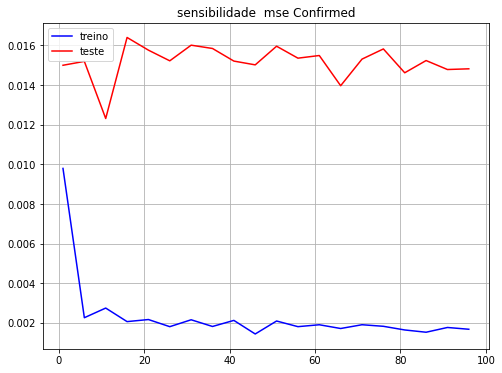

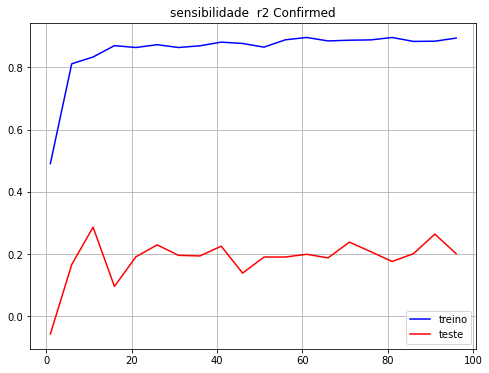

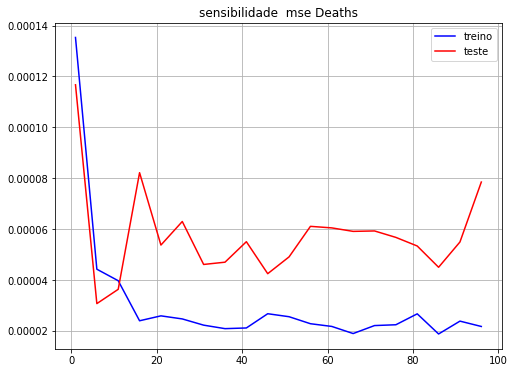

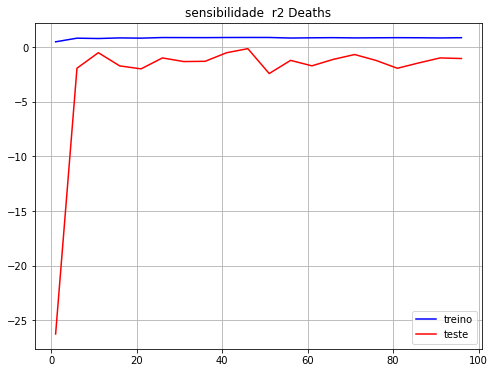

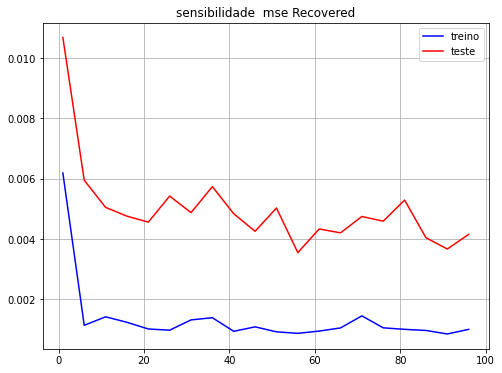

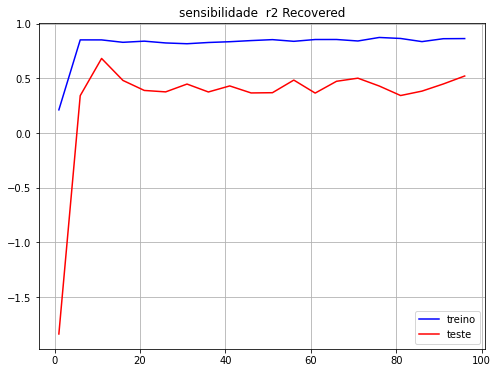

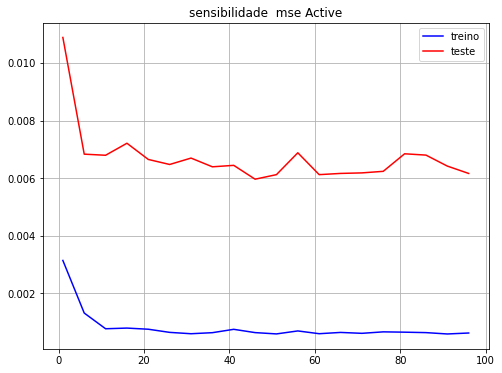

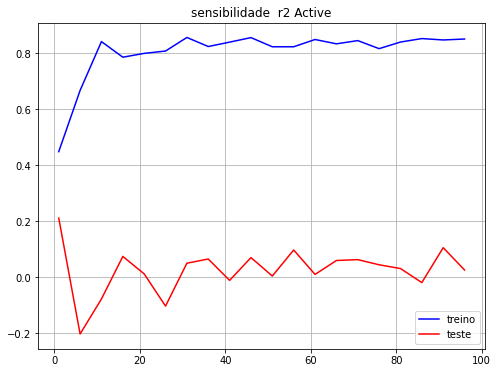

In [77]:
lista_n_arvores = [i for i in range(1, 100, 5)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = RandomForestRegressor(n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict[t], y_train_dict[t])
            train_pred = model.predict(x_train_dict[t])
            test_pred = model.predict(x_test_dict[t])
            train_r2 = metrica(model, x_train_dict[t], y_train_dict[t])
            test_r2 = metrica(model, x_test_dict[t], y_test_dict[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

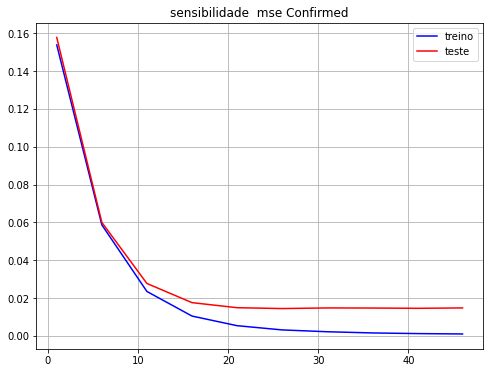

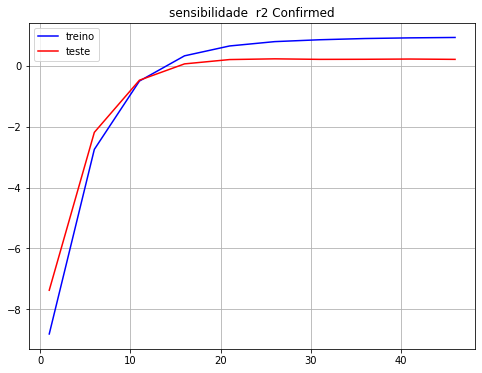

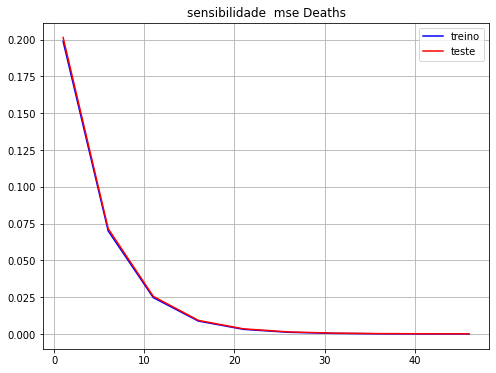

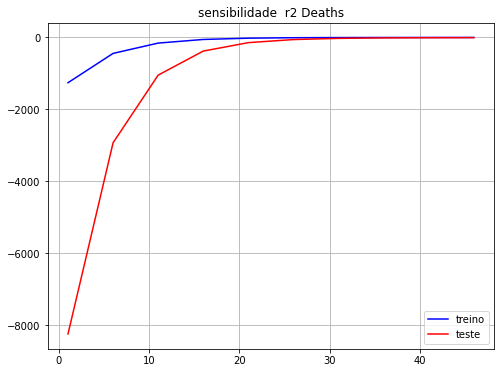

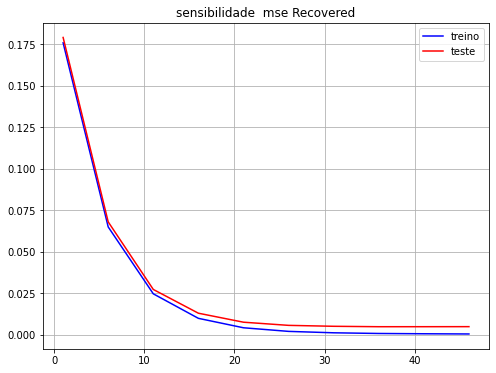

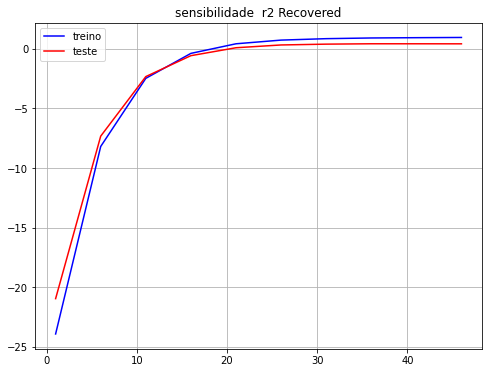

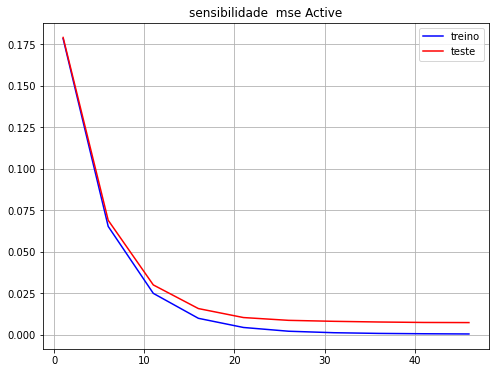

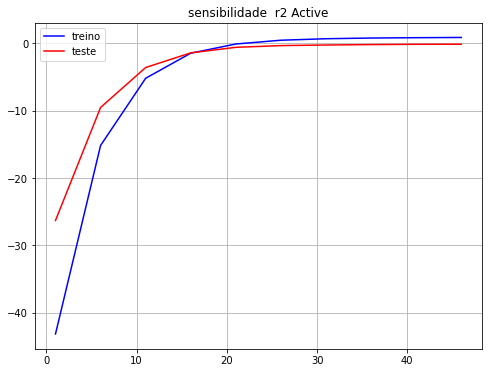

In [78]:
lista_n_arvores = [i for i in range(1, 50, 5)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = xgb.XGBRegressor(n_estimators=n_arvores,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict[t], y_train_dict[t])
            train_pred = model.predict(x_train_dict[t])
            test_pred = model.predict(x_test_dict[t])
            train_r2 = metrica(model, x_train_dict[t], y_train_dict[t])
            test_r2 = metrica(model, x_test_dict[t], y_test_dict[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

## Model selection: otimização

**TODO: testar meta bagging regressor e AdaBoost**

In [79]:
modelos_dict = {'ridge': Ridge(),
                #'lasso': Lasso(),
                #'random forest': RandomForestRegressor(),
                #'gradient boosting':xgb.XGBRegressor(),
                }

ridge_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

lasso_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

rf_param_grid = {'n_estimators':np.arange(1, 40, 1),
                 'max_features': np.arange(1, 20, 1),
                 'max_depth':np.arange(1, 20, 1),
                 'min_samples_split': np.arange(2, 20, 1),
                 "bootstrap": [True, False],
                 'n_jobs': [-1]
                 }

gdbt_param_grid = {'max_depth': np.arange(3, 20, 1),
                   'learning_rate': stats.uniform(loc=0.001, scale=0.7),
                   'n_estimators': [10, 20, 30, 40, 50],
                   'n_jobs': [-1],
                   'gamma': stats.uniform(loc=0.001, scale=10),
                   'subsample': stats.uniform(loc=0.1, scale=0.9),
                   'colsample_bytree': stats.uniform(loc=0.1, scale=0.9),
                   'reg_alpha': stats.uniform(loc=0.001, scale=10),
                   'reg_lambda': stats.uniform(loc=0.01, scale=5),
                   'booster': ['gbtree', 'gblinear', 'dart'],
                   'objective': ['reg:squarederror']
                   }



param_dict = {'ridge':ridge_param_grid,
              #'lasso': lasso_param_grid,
              #'random forest': rf_param_grid,
              #'gradient boosting':gdbt_param_grid,
             }

In [80]:
n_iteracoes = 10

In [81]:
%%time

resultados_dict = {}
otm_time_dict = {}
melhor_modelo_dict = {}
melhor_modelo_nome = {}
melhores_parametros_dict = {}
best_score = {}
resultados = {}

n_folds = 10

loo = LeaveOneOut()

for t in targets:
    _, _, _, resultados[t], _ = busca_aleatoria(x_train_dict[t], y_train_dict[t], Ridge(), param_dict['ridge'], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
    resultados[t]['nome'] = 'ridge'

for t in targets:
    best_score[t] = 1 * [-9999.]
    melhor_modelo_nome[t] = 1 * [None]
    melhor_modelo_dict[t] = 1 * [None]
    melhores_parametros_dict[t] = 1 * [None]
    for nome, modelo in modelos_dict.items():
        print (nome)
        melhor_modelo, melhores_parametros, score, result, otm_time = busca_aleatoria(x_train_dict[t], y_train_dict[t], modelo, param_dict[nome], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
        result['nome'] = nome
        resultados[t] = pd.concat([resultados[t], result])
        if score > min(best_score[t]):
            melhor_modelo_nome[t][np.argmin(best_score[t])] = nome
            melhor_modelo_dict[t][np.argmin(best_score[t])] = melhor_modelo
            melhores_parametros_dict[t][np.argmin(best_score[t])] = melhores_parametros
            best_score[t][np.argmin(best_score[t])] = score



 
 buscando melhores parâmetros...


/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.002222      0.000763         0.001171        0.000338     687.765   
1       0.001796      0.000264         0.000970        0.000144     712.773   
2       0.001976      0.000401         0.001056        0.000200     897.176   
3       0.001693      0.000212         0.000941        0.000110     771.693   
4       0.001679      0.000115         0.000924        0.000036     319.981   
5       0.001714      0.000225         0.000949        0.000117     435.849   
6       0.001763      0.000168         0.000952        0.000090     796.194   
7       0.001731      0.000118         0.000931        0.000045     255.678   
8       0.001693      0.000203         0.000939        0.000107     729.213   
9       0.001897      0.000264         0.001009        0.000108     705.375   

  param_max_iter                                           params  \
0           4000   {'alpha': 687.7651301260173, 'max_iter': 4

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.001557      0.000208         0.000922        0.000107     25.3698   
1       0.001575      0.000312         0.000936        0.000151     78.1439   
2       0.001596      0.000296         0.000945        0.000167     576.851   
3       0.001443      0.000147         0.000869        0.000105     126.827   
4       0.001741      0.000329         0.000995        0.000173     129.406   
5       0.001485      0.000230         0.000889        0.000128     728.735   
6       0.001424      0.000205         0.000847        0.000109     46.7613   
7       0.001424      0.000144         0.001259        0.004631     457.197   
8       0.001463      0.000179         0.000871        0.000082     990.673   
9       0.001409      0.000098         0.000823        0.000033     395.292   

  param_max_iter                                           params  \
0           7000  {'alpha': 25.369849589984977, 'max_iter': 7

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.001420      0.000132         0.000826        0.000043     88.5433   
1       0.001405      0.000121         0.000844        0.000071     233.368   
2       0.001420      0.000113         0.000854        0.000074     768.013   
3       0.001395      0.000130         0.000843        0.000085     277.542   
4       0.001416      0.000151         0.000846        0.000060     723.156   
5       0.001731      0.000300         0.001014        0.000168     134.681   
6       0.001647      0.000348         0.000953        0.000188     704.029   
7       0.001500      0.000210         0.000880        0.000114     753.353   
8       0.001791      0.000261         0.001041        0.000135     900.614   
9       0.001541      0.000305         0.000923        0.000187     141.304   

  param_max_iter                                           params  \
0           5000    {'alpha': 88.5433123166692, 'max_iter': 5

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.001467      0.000186         0.000873        0.000091     101.362   
1       0.001587      0.000340         0.000929        0.000179     214.704   
2       0.001401      0.000150         0.000839        0.000080     419.183   
3       0.001484      0.000199         0.000885        0.000125     413.599   
4       0.001473      0.000167         0.000877        0.000124     431.301   
5       0.001397      0.000130         0.000839        0.000071      999.04   
6       0.001480      0.000158         0.000867        0.000094     452.314   
7       0.001516      0.000193         0.000907        0.000135     319.923   
8       0.001443      0.000139         0.000861        0.000082     318.908   
9       0.001475      0.000177         0.000865        0.000098     460.033   

  param_max_iter                                           params  \
0           4000  {'alpha': 101.36215639404342, 'max_iter': 4

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.001801      0.000183         0.000981        0.000096      201.86   
1       0.001807      0.000182         0.000981        0.000091     326.878   
2       0.002030      0.000349         0.001072        0.000163      467.02   
3       0.001988      0.000190         0.001023        0.000070     457.297   
4       0.002142      0.000240         0.001131        0.000119     285.098   
5       0.002550      0.000500         0.001354        0.000300     709.872   
6       0.002473      0.000443         0.001319        0.000270     962.422   
7       0.002427      0.000535         0.001277        0.000301     861.586   
8       0.002186      0.000307         0.001177        0.000193     577.405   
9       0.002206      0.000368         0.001162        0.000195     469.632   

  param_max_iter                                           params  \
0           7000  {'alpha': 201.85976185473106, 'max_iter': 7

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.001808      0.000233         0.001042        0.000142     765.278   
1       0.001769      0.000118         0.001000        0.000043     195.377   
2       0.001808      0.000234         0.001041        0.000142     153.631   
3       0.001897      0.000287         0.001099        0.000173     909.014   
4       0.001877      0.000331         0.001081        0.000196     390.516   
5       0.001828      0.000184         0.001042        0.000094     369.841   
6       0.001816      0.000270         0.001050        0.000148     987.497   
7       0.001929      0.000304         0.001102        0.000162     828.878   
8       0.002098      0.000419         0.001199        0.000243     346.524   
9       0.001860      0.000314         0.001062        0.000193     816.145   

  param_max_iter                                           params  \
0           4000   {'alpha': 765.2775905221101, 'max_iter': 4

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.002206      0.000348         0.001260        0.000166     899.994   
1       0.001777      0.000238         0.001036        0.000155     313.482   
2       0.001762      0.000155         0.001009        0.000094     164.341   
3       0.001712      0.000103         0.001004        0.000078     93.2661   
4       0.001768      0.000157         0.001009        0.000082     379.816   
5       0.001749      0.000099         0.001009        0.000101     199.516   
6       0.001787      0.000235         0.001031        0.000154     76.8708   
7       0.001812      0.000247         0.001025        0.000143     889.096   
8       0.001751      0.000135         0.000998        0.000061     163.724   
9       0.001807      0.000259         0.001024        0.000137     798.847   

  param_max_iter                                           params  \
0           3000    {'alpha': 899.993971895705, 'max_iter': 3

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.001878      0.000318         0.001053        0.000180     362.668   
1       0.001876      0.000292         0.001077        0.000173     415.331   
2       0.001795      0.000258         0.001037        0.000161     527.991   
3       0.001802      0.000269         0.001051        0.000181     922.497   
4       0.001779      0.000132         0.001010        0.000080     212.815   
5       0.002277      0.000369         0.001290        0.000230      915.85   
6       0.001945      0.000284         0.001107        0.000159     179.538   
7       0.001821      0.000280         0.001043        0.000151     480.824   
8       0.001773      0.000130         0.001016        0.000088     817.087   
9       0.001774      0.000174         0.001023        0.000117     567.671   

  param_max_iter                                           params  \
0           8000   {'alpha': 362.6679409743034, 'max_iter': 8

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning

In [82]:
for t in targets:
    print (resultados[t].shape)
    resultados[t].sort_values(by='mean_test_'+list(metricas.keys())[0], inplace=True, ascending=False)

(20, 268)
(20, 268)
(20, 268)
(20, 268)


In [83]:
resultados['Recovered'].head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_mse,split1_test_mse,split2_test_mse,...,split121_test_r2,split122_test_r2,split123_test_r2,split124_test_r2,split125_test_r2,split126_test_r2,mean_test_r2,std_test_r2,rank_test_r2,nome
6,0.001787,0.000235,0.001031,0.000154,76.8708,2000,"{'alpha': 76.87081929942482, 'max_iter': 2000}",0.002258,0.003206,0.002011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,ridge
0,0.001420,0.000132,0.000826,0.000043,88.5433,5000,"{'alpha': 88.5433123166692, 'max_iter': 5000}",0.002187,0.003089,0.002013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ridge
3,0.001712,0.000103,0.001004,0.000078,93.2661,7000,"{'alpha': 93.26605198634927, 'max_iter': 7000}",0.002161,0.003048,0.002014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,ridge
5,0.001731,0.000300,0.001014,0.000168,134.681,5000,"{'alpha': 134.68143109199858, 'max_iter': 5000}",0.001997,0.002796,0.002011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,ridge
9,0.001541,0.000305,0.000923,0.000187,141.304,1000,"{'alpha': 141.30437029615592, 'max_iter': 1000}",0.001977,0.002767,0.002009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,ridge
8,0.001751,0.000135,0.000998,0.000061,163.724,2000,"{'alpha': 163.7243609227966, 'max_iter': 2000}",0.001917,0.002685,0.002003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,ridge
2,0.001762,0.000155,0.001009,0.000094,164.341,9000,"{'alpha': 164.34148681165115, 'max_iter': 9000}",0.001916,0.002683,0.002003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,ridge
5,0.001749,0.000099,0.001009,0.000101,199.516,9000,"{'alpha': 199.5159713406186, 'max_iter': 9000}",0.001841,0.002585,0.001990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,ridge
1,0.001405,0.000121,0.000844,0.000071,233.368,6000,"{'alpha': 233.36828779515747, 'max_iter': 6000}",0.001783,0.002515,0.001975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,ridge
3,0.001395,0.000130,0.000843,0.000085,277.542,3000,"{'alpha': 277.5421737120868, 'max_iter': 3000}",0.001719,0.002445,0.001955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,ridge


## Testar modelo

**TODO: adicionar mais métricas no teste**

In [84]:

for t in targets:
    for modelo in melhor_modelo_dict[t]:
        if modelo == None: continue
        modelo.fit(x_train_dict[t], y_train_dict[t])

train_scores = {}
test_scores = {}
biases = {}
variances = {}

for met_nome, metrica in metricas.items():
    for t in targets:
        train_scores[t] = []
        test_scores[t] = []
        biases[t] = []
        variances[t] = []
        for modelo in melhor_modelo_dict[t]:
            if modelo == None: continue
            train_scores[t].append(metrica(modelo, x_train_dict[t], y_train_dict[t]).round(2)) 
            test_scores[t].append(metrica(modelo, x_test_dict[t], y_test_dict[t]).round(2))
            biases[t].append(1.0 - metrica(modelo, x_train_dict[t], y_train_dict[t]))
            variances[t].append(metrica(modelo, x_train_dict[t], y_train_dict[t]) - metrica(modelo, x_test_dict[t], y_test_dict[t]))
            print ( met_nome + ": score de treino " + str(metrica(modelo, x_train_dict[t], y_train_dict[t]).round(2)) + " e score de teste: " + str(metrica(modelo, x_test_dict[t], y_test_dict[t]).round(2)) + " para target: " + str(t))


mse: score de treino 0.01 e score de teste: 0.02 para target: Confirmed
mse: score de treino 0.0 e score de teste: 0.0 para target: Deaths
mse: score de treino 0.01 e score de teste: 0.01 para target: Recovered
mse: score de treino 0.0 e score de teste: 0.01 para target: Active
r2: score de treino 0.18 e score de teste: 0.12 para target: Confirmed
r2: score de treino 0.1 e score de teste: -0.16 para target: Deaths
r2: score de treino 0.18 e score de teste: 0.13 para target: Recovered
r2: score de treino 0.08 e score de teste: -0.01 para target: Active
